Solving question 7, is there a relation between time of visits and productivity?
we will use average visits time of the rep in the day and number of visits in the day and perform some hypothesis tests

The following pipeline was used to produce the data, it aggregates visits on day to calculate total duration time and num of visits made on that day for each user in a given company, it keeps data with visits > 3, and total duration of presentations > 10 minutes

In [ ]:
'''
The following query was used on mongo db to retrieve the data for a single company

[
    {
        '$match': {
            'company_id': ObjectId('5b98d0eafb6fc01dae4341c5')
        }
    }, {
        '$unwind': {
            'path': '$calls'
        }
    }, {
        '$addFields': {
            'day': {
                '$concat': [
                    {
                        '$toString': {
                            '$year': '$calls.start_timestamp'
                        }
                    }, '-', {
                        '$toString': {
                            '$month': '$calls.start_timestamp'
                        }
                    }, '-', {
                        '$toString': {
                            '$dayOfMonth': '$calls.start_timestamp'
                        }
                    }
                ]
            }, 
            'timestamp': {
                '$hour': '$calls.start_timestamp'
            }
        }
    }, {
        '$group': {
            '_id': {
                'user_id': '$user.id', 
                'dayOfMonth': '$day'
            }, 
            'total_duration': {
                '$sum': '$calls.duration'
            }, 
            'avg_timestamp': {
                '$avg': '$timestamp'
            }, 
            'visitsNum': {
                '$sum': 1
            }
        }
    }, {
        '$match': {
            'visitsNum': {
                '$gt': 3
            }, 
            'total_duration': {
                '$gt': 600
            }, 
            'avg_timestamp': {
                '$gt': 5
            }
        }
    }, {
        '$project': {
            'userid': '$_id.user_id', 
            'day': '$_id.dayOfMonth', 
            'totalDurationTime': '$total_duration', 
            'averageVisitsTime': '$avg_timestamp', 
            'visitsNum': '$visitsNum'
        }
    }
]

'''

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('visitsPerDay.csv')

In [4]:
df.head()

,userid,day,totalDurationTime,averageVisitsTime,visitsNum
0,621dd65e26d90d2838e4fdbd,3/13/2023,2783,14.583333,12
1,6061c07af7606271c5c4da3d,10/11/2022,5241,16.941176,17
2,628b3d307ee2c0232015abd5,10/12/2022,1631,13.090909,11
3,5da46ce7565e290015188597,4/1/2023,2140,14.083333,12
4,5da46f92565e2900151885b8,3/7/2023,1694,18.700000,10


In [3]:
df.describe()

,totalDurationTime,averageVisitsTime,visitsNum
count,3822.000000,3822.000000,3822.000000
mean,2483.042125,16.369463,10.862376
std,7767.322204,2.267639,3.178194
min,602.000000,8.857143,4.000000
25%,1146.250000,14.666667,9.000000
50%,1805.000000,16.166667,10.000000
75%,2683.750000,17.854396,13.000000
max,245089.000000,23.000000,35.000000


In [4]:
#Remove outliers in totalDurationTime using percentile
df = df[df.totalDurationTime < df.totalDurationTime.quantile(.95)]

In [5]:
df.describe()

,totalDurationTime,averageVisitsTime,visitsNum
count,3630.000000,3630.000000,3630.000000
mean,1926.543802,16.403154,10.736639
std,1009.952169,2.286213,3.104510
min,602.000000,8.857143,4.000000
25%,1120.750000,14.700000,9.000000
50%,1727.500000,16.200000,10.000000
75%,2490.000000,17.900000,12.000000
max,5259.000000,23.000000,35.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 0 to 3821
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   userid             3630 non-null   object 
 1   day                3630 non-null   object 
 2   totalDurationTime  3630 non-null   int64  
 3   averageVisitsTime  3630 non-null   float64
 4   visitsNum          3630 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 170.2+ KB


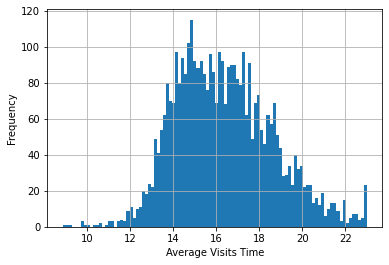

In [5]:
#Plot the distribution of averageVisitsTime
df.averageVisitsTime.hist(bins=100)
plt.xlabel('Average Visits Time')
plt.ylabel('Frequency')
plt.show()

Let's test the following hypothesis:
Days with averageVisitsTime between 12 and 17 have visitsNum less than days with averageVisits Time before 12 or after 17

In [8]:
df_12_17 = df[(df.averageVisitsTime >= 12) & (df.averageVisitsTime <= 15)]
df_rest = df[(df.averageVisitsTime < 12) | (df.averageVisitsTime > 15)]

n_12_17 = df_12_17.shape[0]
n_rest = df_rest.shape[0]

mean_12_17 = df_12_17.visitsNum.mean()
mean_rest = df_rest.visitsNum.mean()

std_12_17 = df_12_17.visitsNum.std()
std_rest = df_rest.visitsNum.std()

print('Number of users with average visit time between 12 and 17: ', n_12_17)
print('Number of users with average visit time outside 12 and 17: ', n_rest)

print(mean_12_17, mean_rest)

Number of users with average visit time between 12 and 17:  1120
Number of users with average visit time outside 12 and 17:  2510
10.871428571428572 10.676494023904382


In [9]:
Z = (mean_rest - mean_12_17) / (std_12_17**2 / n_12_17 + std_rest**2 / n_rest)**0.5
print('Z-score: ', Z)

Z-score:  -1.8236341235091715


We will retain the null hypothesis which means those who work between 12 and 17 don't necessarily perform worse than those who work at other parts of the day

Let's test another hypothesis, that those who work at night, after 5pm, make less visits on average than those who work before 5 pm

In [10]:
df_after_17 = df[df.averageVisitsTime >= 17]
df_before_17 = df[df.averageVisitsTime < 17]

n_after_17 = df_after_17.shape[0]
n_before_17 = df_before_17.shape[0]

mean_after_17 = df_after_17.visitsNum.mean()
mean_before_17 = df_before_17.visitsNum.mean()

std_after_17 = df_after_17.visitsNum.std()
std_before_17 = df_before_17.visitsNum.std()

print('Number of users with average visit time after 5pm: ', n_after_17)
print('Number of users with average visit time before 5pm: ', n_before_17)

print(mean_after_17, mean_before_17)

Number of users with average visit time after 5pm:  1397
Number of users with average visit time before 5pm:  2233
10.425912670007158 10.931034482758621


In [11]:
Z = (mean_before_17 - mean_after_17) / (std_after_17**2 / n_after_17 + std_before_17**2 / n_before_17)**0.5
print('Z-score: ', Z)

Z-score:  4.7723575688853055


In [12]:
#Calculate P value
from scipy.stats import norm
p = norm.sf(Z)
print('P value: ', p)

P value:  9.104093456632667e-07


Since p value is < 0.05 we can reject the null hypothesis which is The average num of visits per day is the same

Let's repeat the same hypothesis tests but using total presentation duration times as the productivity measure

In [14]:
mean_12_17 = df_12_17.totalDurationTime.mean()
mean_rest = df_rest.totalDurationTime.mean()

std_12_17 = df_12_17.totalDurationTime.std()
std_rest = df_rest.totalDurationTime.std()

Z = (mean_rest - mean_12_17) / (std_12_17**2 / n_12_17 + std_rest**2 / n_rest)**0.5
print('Z-score: ', Z)

print(mean_12_17, mean_rest)

Z-score:  -2.703274043371748
1995.5794642857143 1895.7390438247012


The null hypothesis will be retained as well that there is no difference between those whose who work at rush hour and others

In [18]:
n_after_17 = df_after_17.shape[0]
n_before_17 = df_before_17.shape[0]

mean_after_17 = df_after_17.totalDurationTime.mean()
mean_before_17 = df_before_17.totalDurationTime.mean()

std_after_17 = df_after_17.totalDurationTime.std()
std_before_17 = df_before_17.totalDurationTime.std()

Z = (mean_before_17 - mean_after_17) / (std_after_17**2 / n_after_17 + std_before_17**2 / n_before_17)**0.5
print('Z-score: ', Z)

Z-score:  3.276612877223941


In [19]:
p = norm.sf(Z)
print('P value: ', p)

P value:  0.0005253015427523482


Again the null hypothesis is rejected and we can conclude the following:

1- Those who work at average time of rush hour between 12pm and 5pm don't have less productivity than others

2- Those who work at day shift (before 5 PM) have higher productivity than those who work at night shift (after 5pm)